# Time Series for Patient 1000004

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from dateutil.parser import parse

## Load and Parse the data into Time Series
The individual patients data have been extracted and stored in a separated folder. Each file named as patient.id.csv.

In [2]:
#dateparse = lambda d: pd.datetime.strptime(d, "%Y-%m")
dateparse = lambda d: parse(d)
df = pd.read_csv("patients_data/analyses/patient.1000004.csv", parse_dates = \
                 ['Datetime'], index_col = "Datetime", date_parser=dateparse)

What are the unique dates in this patient's timeline? 

In [3]:
np.unique(df.index.date)

array([datetime.date(2016, 4, 11), datetime.date(2016, 4, 12),
       datetime.date(2016, 4, 13), datetime.date(2016, 4, 14),
       datetime.date(2016, 4, 15), datetime.date(2016, 4, 16),
       datetime.date(2016, 4, 17), datetime.date(2016, 4, 18),
       datetime.date(2016, 4, 19), datetime.date(2016, 4, 20),
       datetime.date(2016, 4, 21), datetime.date(2016, 4, 22),
       datetime.date(2016, 4, 23), datetime.date(2016, 4, 24),
       datetime.date(2016, 4, 25), datetime.date(2016, 4, 26),
       datetime.date(2016, 4, 27), datetime.date(2016, 4, 28),
       datetime.date(2016, 4, 29), datetime.date(2016, 4, 30),
       datetime.date(2016, 5, 1), datetime.date(2016, 5, 2)], dtype=object)

What is the earlist time and latest time in the timeline?

In [4]:
print(np.min(df.index))
print ('-' * 10)
print(np.max(df.index))

2016-04-11 14:22:00
----------
2016-05-02 00:05:00


How many records in total for this patient?

In [5]:
df.shape

(29384, 17)

## Use the 'steps' for Time Series Analysis
First, extract the 'steps' from the patient data and put it as an individual time series

In [6]:
ts = df['Steps']

In [11]:
ts['2016-04-11'][300:305]

Datetime
2016-04-11 19:22:00    52
2016-04-11 19:23:00    47
2016-04-11 19:24:00    37
2016-04-11 19:25:00    41
2016-04-11 19:26:00    14
Name: Steps, dtype: int64

This patient's steps record doesn't have missing values. If there is a missing values, a forward filling can be done in reindex() method.

In [12]:
ts.isnull().sum()

0

Plot the 'steps' for this patients

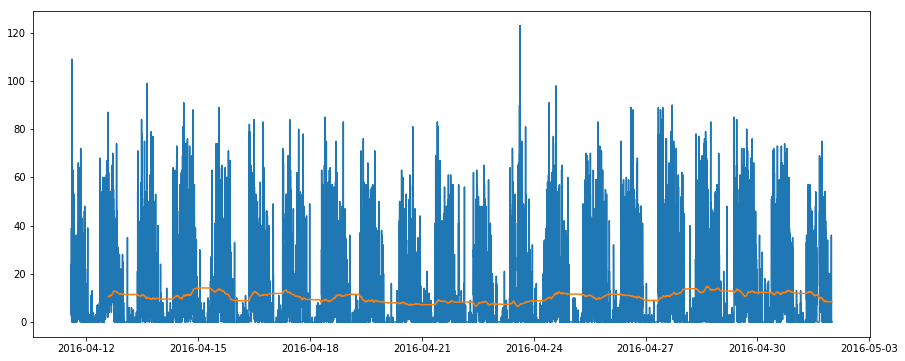

In [13]:
plt.plot(ts)
plt.plot(ts.rolling(1440).mean())

Resample the TS from minute steps to hourly steps

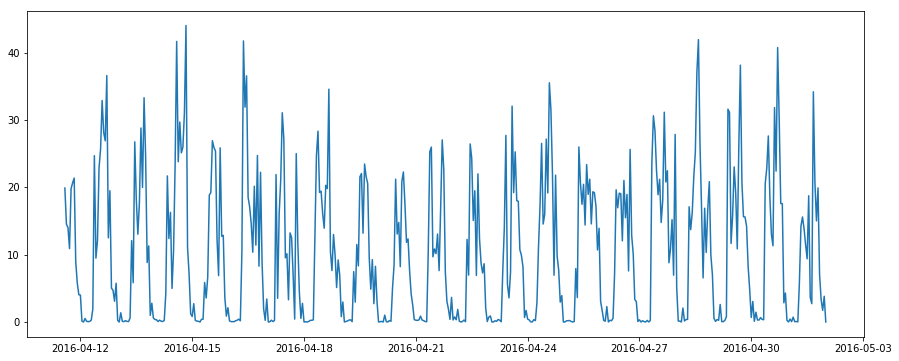

In [14]:
ts_hourly = ts.resample(rule="H").mean()
plt.plot(ts_hourly)

In [15]:
# Compute and print the autocorrelation of hourly steps
autocorrelation = ts_hourly.autocorr()
print("The autocorrelation of hourly steps is %4.2f" %(autocorrelation))

The autocorrelation of hourly steps is 0.69


In [16]:
# Compute and print the autocorrelation of minutes steps
autocorrelation = ts.autocorr()
print("The autocorrelation of minutes steps is %4.2f" %(autocorrelation))

The autocorrelation of minutes steps is 0.72


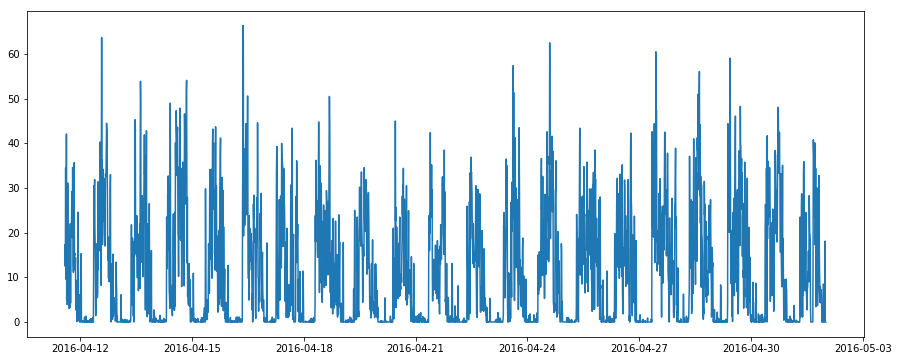

In [17]:
# resample to x minutes steps mean
ts_T = ts.resample(rule="10T").mean()
plt.plot(ts_T)

In [18]:
# Compute and print the autocorrelation of x minutes steps
autocorrelation = ts_T.autocorr()
print("The autocorrelation of x minutes steps is %4.2f" %(autocorrelation))

The autocorrelation of x minutes steps is 0.76


## Is the Series Stationary?
Use the Dickey-Fuller test to test whether the time series of 'steps' is stationary.

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. Stationary series has regularity in its behavior and we can model and analyse stationary series using ARIMA models. 

For practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:
- constant mean
- constant variance
- an autocovariance that does not depend on time.

**Dickey-Fuller Test**: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

**Augmented Dickey-Fuller (ADF) Test**: The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

**Other Use**: With the ADF test, the "null hypothesis" (the hypothesis that we either reject or fail to reject) is that the series follows a random walk. Therefore, a low p-value (say less than 5%) means we can reject the null hypothesis that the series is a random walk.

In [19]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling_number = 1):
    # 1440 is the number of minutes in a day; that means by default,
    # the test is on the daily mean and std
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=rolling_number).mean()
    rolstd = timeseries.rolling(window=rolling_number).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], \
                         index=['Test Statistic','p-value',\
                                '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


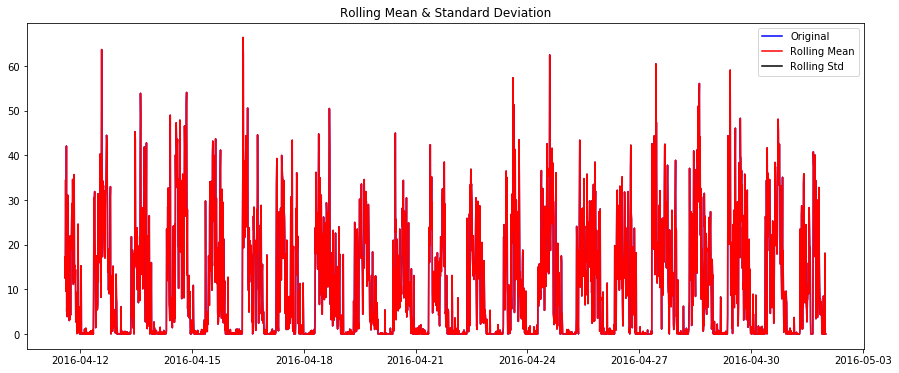

Results of Dickey-Fuller Test:
Test Statistic                -8.052186e+00
p-value                        1.730147e-12
#Lags Used                     1.700000e+01
Number of Observations Used    2.921000e+03
Critical Value (1%)           -3.432591e+00
Critical Value (5%)           -2.862530e+00
Critical Value (10%)          -2.567297e+00
dtype: float64


In [20]:
test_stationarity(ts_T)

In [22]:
float(-8.052186e+00)

-8.052186

The test statistics is less than all the critial values. The TS is stationary and is not a random walk!

## Compute ACF and PACF
The autocorrelation and partial autocorrelation functions give us some ideas about the orders of the ARIMA model for simulating the TS

In [23]:
# Import the modules for simulating data and for plotting the and ACF and PACF
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf

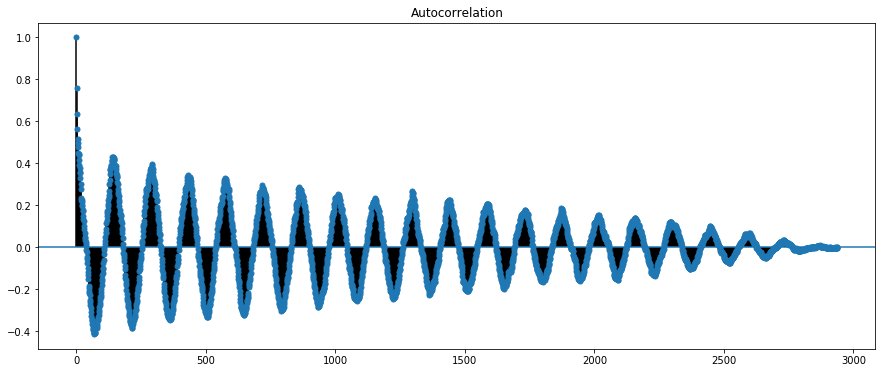

In [24]:
x = plot_acf(ts_T, alpha = 1)

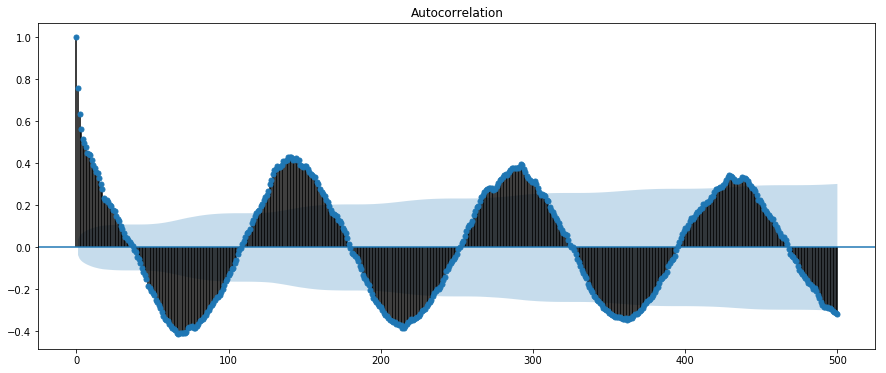

In [25]:
# Plot the autocorrelation function with 95% confidence intervals 
# and 500 lags using plot_acf
x = plot_acf(ts_T, alpha=0.05, lags = 500)

## Decomposing Trend and Seasonality

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

Observations:
- The trend shows the patient's overall activities move slightly downward. 
- There is a strong seasonality in the activities.

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [27]:
decomposition = seasonal_decompose(ts, freq= 2880)

In [28]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

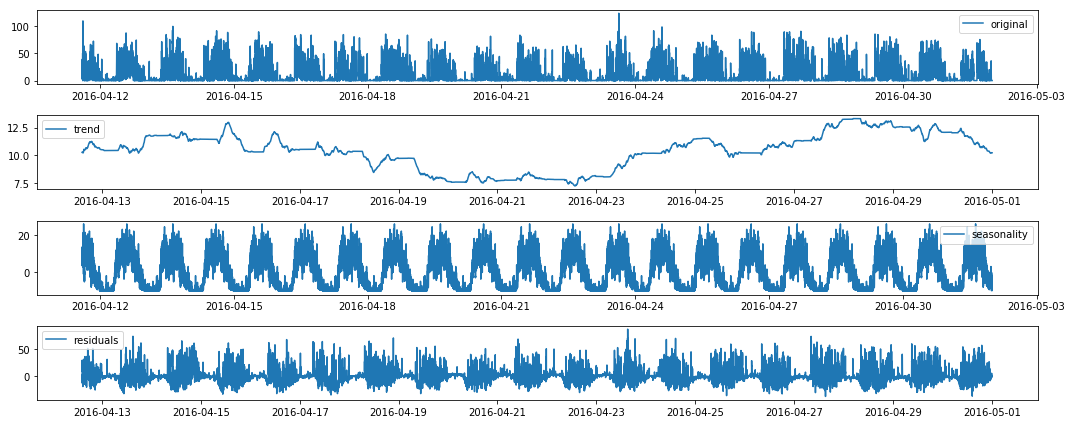

In [29]:
plt.subplot(411)
plt.plot(ts, label="original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label="seasonality")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label="residuals")
plt.legend(loc='best')
plt.tight_layout()

## Seasonal Adjustment for Steps

For seasonal adjustments, instead of taking first differences, we will take differences with a lag corresponding to the periodicity.

Look again at the ACF of the 10-minute step means. The autocorrelation is high for lags 75, 150, 225, 300, ... because of the spike in steps every 12 hours (720 minutes) during moninoring period. Apply a seasonal adjustment by taking the 144 lags (144 represents the periodicity of the series). Then compute the autocorrelation of the transformed series.

In [30]:
ts_T_sa = ts_T.diff(144)
print(ts_T_sa[:5])

Datetime
2016-04-11 14:20:00   NaN
2016-04-11 14:30:00   NaN
2016-04-11 14:40:00   NaN
2016-04-11 14:50:00   NaN
2016-04-11 15:00:00   NaN
Freq: 10T, Name: Steps, dtype: float64


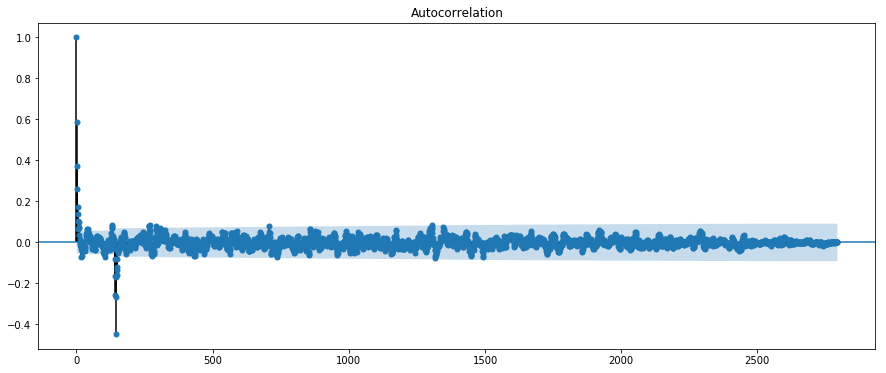

In [31]:
# Drop the NaN data in the rows
ts_T_sa = ts_T_sa.dropna()

# Plot the autocorrelation function of the seasonally adjusted series
x = plot_acf(ts_T_sa, alpha=0.05)

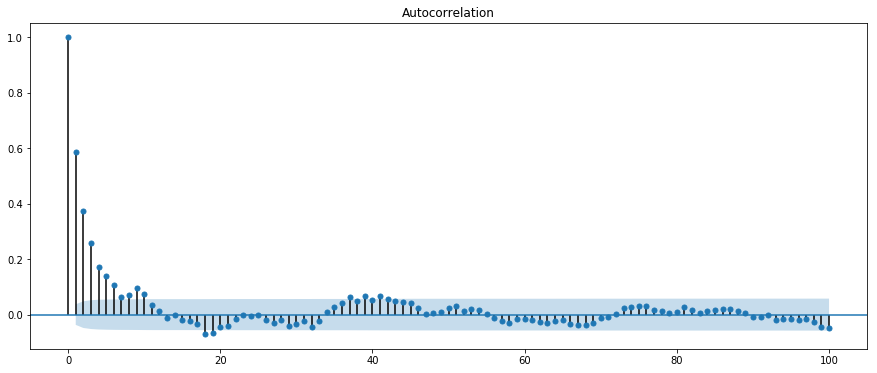

In [32]:
# Plot the autocorrelation function of the seasonally adjusted series in 100 lags
x = plot_acf(ts_T_sa, alpha=0.05, lags = 100)

## Estimating an AR Model
We will estimate the AR(1) parameter, ϕ, of the 10-minute average steps.

- Import the class ARMA in the module statsmodels.tsa.arima_model.
- Create an instance of the ARMA class called mod using the data and the order (p,q) of the model (in this case, for an AR(1)), is order=(1,0).
- Fit the model mod using the method .fit() and save it in a results object called res.
- Print out the entire summmary of results using the .summary() method.
- Just print out an estimate of the constant and ϕ using the .params attribute (no parentheses).

In [33]:
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Fit an AR(1) model to the first simulated data
mod = ARMA(ts_T_sa, order=(1,0))
res = mod.fit()

/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [34]:
# Print out summary information on the fit
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                  Steps   No. Observations:                 2795
Model:                     ARMA(1, 0)   Log Likelihood              -10569.735
Method:                       css-mle   S.D. of innovations             10.619
Date:                Tue, 17 Apr 2018   AIC                          21145.470
Time:                        10:23:05   BIC                          21163.277
Sample:                    04-12-2016   HQIC                         21151.898
                         - 05-02-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0947      0.485     -0.195      0.845      -1.046       0.857
ar.L1.Steps     0.5864      0.015     38.270      0.000       0.556       0.616
                                    Roots       

/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [35]:
# Print out the estimate for the constant and for phi
print(res.params)

const         -0.094749
ar.L1.Steps    0.586384
dtype: float64


The AR(1) model looks like: $y_{t} = 0.58y_{t-1} + w_{t}$, where $w_t$ is white noise.

## Forcasting
ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model.

- **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

## Forecasting with an AR Model

We can do forecasting, both in-sample and out-of-sample using statsmodels. The in-sample is a forecast of the next data point using the data up to that point, and the out-of-sample forecasts any number of data points in the future. These forecasts can be made using either the predict() method or using the plot_predict() method.

/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


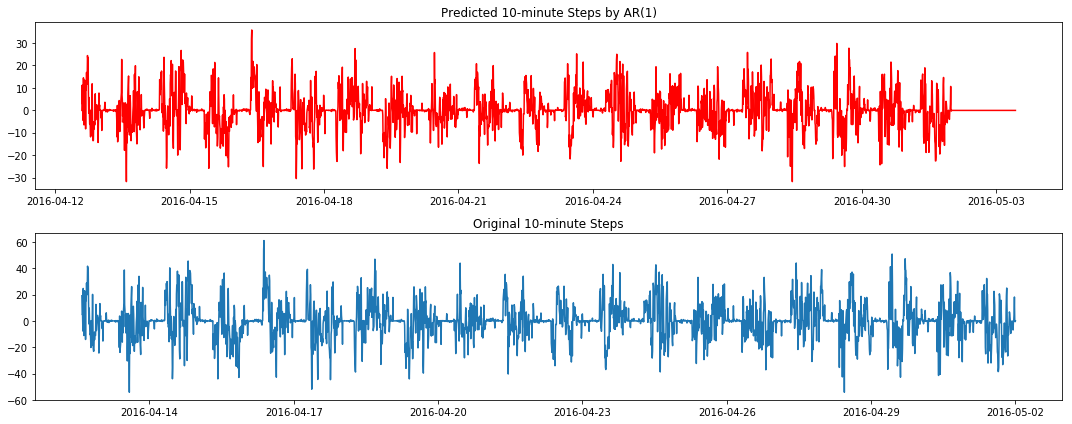

In [36]:
# Plot the original series and the forecasted series
plt.subplot(2,1,1)
x = res.predict(start=0, end=3000)
plt.plot(x, color="red")
plt.title("Predicted 10-minute Steps by AR(1)")

plt.subplot(2, 1, 2)
plt.plot(ts_T_sa)
plt.title("Original 10-minute Steps")
plt.tight_layout()

## Estimate Order of Model: PACF
One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF). Notice that for an AR(1), the PACF should have a significant lag-1 value, and roughly zeros after that. And for an AR(2), the PACF should have significant lag-1 and lag-2 values, and zeros after that.... 

Just like we used the plot_acf function earlier, here we will use a function called plot_pacf in the statsmodels module.

* Import the modules for simulating data and for plotting the PACF

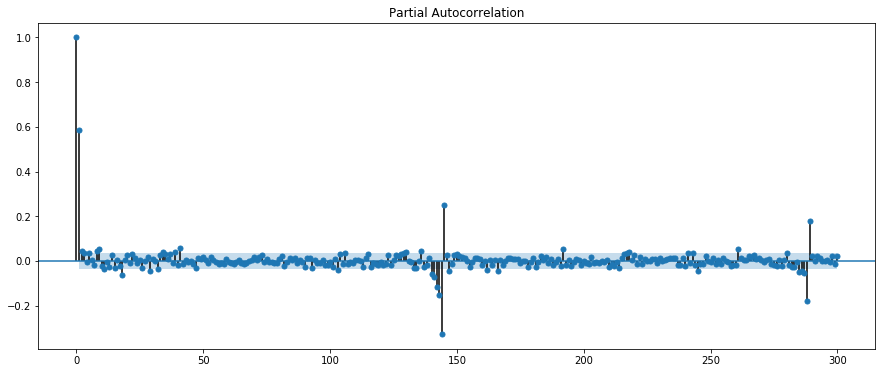

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf
x= plot_pacf(ts_T_sa, lags=300)

## Estimate Order of Model: Information Criteria
Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model. 

- Initialize a numpy array BIC, which we will use to store the BIC for each AR(p) model.
- Loop through order p for p = 0,...,6.
- For each p, fit the data to an AR model of order p.
- For each p, save the value of BIC using the .bic attribute (no parentheses) of res.
- Plot BIC as a function of p (for the plot, skip p=0 and plot for p=1,...6).

/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


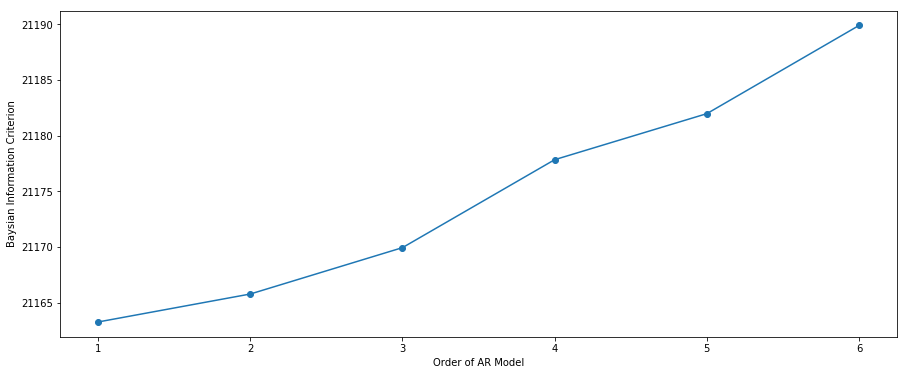

In [38]:
# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(ts_T_sa, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Baysian Information Criterion')
plt.show()

## Estimating a MA Model
Unlike an AR(1), an MA(1) model has no autocorrelation beyond lag 1, an MA(2) model has no autocorrelation beyond lag 2, etc. The lag-1 autocorrelation for an MA(1) model is not θ, but rather θ/(1+θ*θ). For example, if the MA parameter, θ, is = +0.9, the first-lag autocorrelation will be 0.9/(1+(0.9)2)=0.497, and the autocorrelation at all other lags will be zero. If the MA parameter, θ, is -0.9, the first-lag autocorrelation will be −0.9/(1+(−0.9)2)=−0.497.


In [39]:
# Fit an MA(1) model to the data
mod = ARMA(ts_T_sa, order=(0,1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                  Steps   No. Observations:                 2795
Model:                     ARMA(0, 1)   Log Likelihood              -10726.319
Method:                       css-mle   S.D. of innovations             11.231
Date:                Tue, 17 Apr 2018   AIC                          21458.637
Time:                        10:23:37   BIC                          21476.444
Sample:                    04-12-2016   HQIC                         21465.065
                         - 05-02-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1013      0.315     -0.322      0.748      -0.719       0.516
ma.L1.Steps     0.4833      0.014     34.460      0.000       0.456       0.511
                                    Roots       

/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [40]:
print(res.params)

const         -0.101343
ma.L1.Steps    0.483293
dtype: float64


## Forecasting with MA Model
As we did with AR models, we will use MA models to forecast in-sample and out-of-sample data using statsmodels.


* Plot the in-sample and out-of-sample forecasts of the data using the .plot_predict() method.

/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


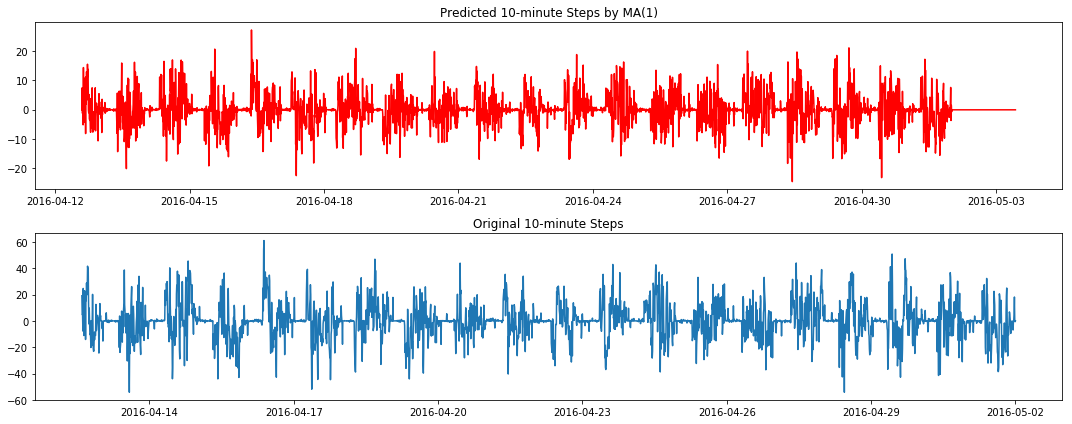

In [41]:
plt.subplot(211)
x= res.predict(start=0, end =3000)
plt.plot(x, color="red")
plt.title("Predicted 10-minute Steps by MA(1)")

plt.subplot(212)
plt.plot(ts_T_sa)
plt.title("Original 10-minute Steps")
plt.tight_layout()

/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


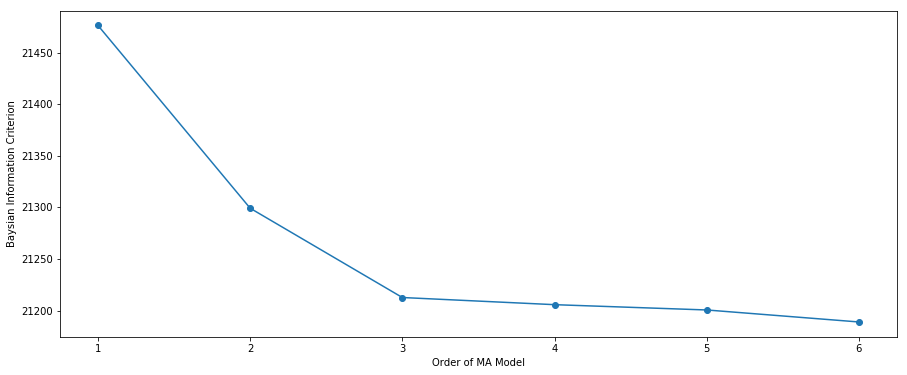

In [42]:
# Fit the data to an MA(q) for q = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for q in range(7):
    mod = ARMA(ts_T_sa, order=(0,q))
    res = mod.fit()
# Save BIC for MA(q)    
    BIC[q] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of MA Model')
plt.ylabel('Baysian Information Criterion')
plt.show()

## Estimating and an ARIMA Model and Forcasting

This time we will combin the AR and MA model to fit a ARIMA model with paramters (p, d, q), where p=1, q=1, and d = 0. 

In [43]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(ts_T_sa, order=(1,0,1))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                  Steps   No. Observations:                 2795
Model:                     ARMA(1, 1)   Log Likelihood              -10566.660
Method:                       css-mle   S.D. of innovations             10.607
Date:                Tue, 17 Apr 2018   AIC                          21141.321
Time:                        10:23:50   BIC                          21165.063
Sample:                    04-12-2016   HQIC                         21149.892
                         - 05-02-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0936      0.512     -0.183      0.855      -1.098       0.910
ar.L1.Steps     0.6417      0.026     25.055      0.000       0.591       0.692
ma.L1.Steps    -0.0847      0.034     -2.496    

/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [44]:
print(res.params)

const         -0.093616
ar.L1.Steps    0.641679
ma.L1.Steps   -0.084710
dtype: float64


/Users/yan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


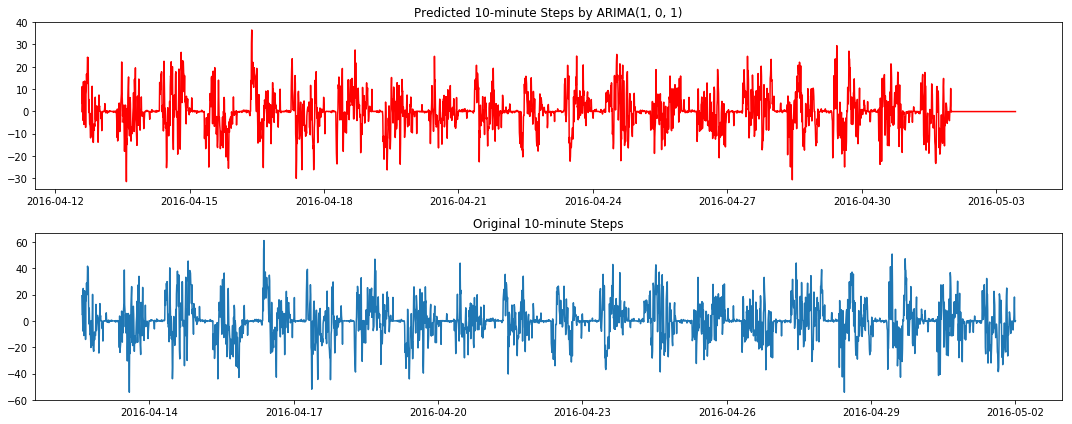

In [45]:
plt.subplot(211)
x= res.predict(start=0, end =3000)
plt.plot(x, color="red")
plt.title("Predicted 10-minute Steps by ARIMA(1, 0, 1)")

plt.subplot(212)
plt.plot(ts_T_sa)
plt.title("Original 10-minute Steps")
plt.tight_layout()